# Assignment 5 - Population

For the PFDA Module

Author: Kyra Menai Hamilton

## Import Packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Getting the data

download as CSV file from CSO website - API Data Query > Format (CSV) > RESTful (URL)

In [2]:
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en"
df = pd.read_csv(url)
print(df.head(5))
print(df.tail(5))

   STATISTIC Statistic Label  TLIST(A1)  CensusYear C02199V02655         Sex  \
0  FY006AC01      Population       2022        2022            -  Both sexes   
1  FY006AC01      Population       2022        2022            -  Both sexes   
2  FY006AC01      Population       2022        2022            -  Both sexes   
3  FY006AC01      Population       2022        2022            -  Both sexes   
4  FY006AC01      Population       2022        2022            -  Both sexes   

  C02076V03371 Single Year of Age                          C03789V04537  \
0            -           All ages                                   IE0   
1            -           All ages  2ae19629-1492-13a3-e055-000000000001   
2            -           All ages  2ae19629-1433-13a3-e055-000000000001   
3            -           All ages  2ae19629-149f-13a3-e055-000000000001   
4            -           All ages  2ae19629-14a0-13a3-e055-000000000001   

                 Administrative Counties    UNIT    VALUE  
0       

## Cleaning the data

Following a data sanity check - Can see that the data imported has included the "Both Sexes" section - to sort this the data will be cleaned. Only want to focus on male vs female so need to remove the Boith seces and define the sexes

In [3]:
print(df['Sex'].unique())
print(df['Sex'].value_counts())

['Both sexes' 'Male' 'Female']
Sex
Both sexes    3264
Male          3264
Female        3264
Name: count, dtype: int64


In [4]:
df = df[df['Sex'].str.strip().str.lower().isin(['male', 'female'])]

# Could have used df = df[df['Sex'] != 'Both sexes'] but I kept it more general to avoid any potential issues with spacing or casing.

There are several colums within the dataset. For this analysis we will be focussing on sexes, age, and region.
Check the columns present within the dataset.

In [5]:
headers = df.columns.tolist()
headers

['STATISTIC',
 'Statistic Label',
 'TLIST(A1)',
 'CensusYear',
 'C02199V02655',
 'Sex',
 'C02076V03371',
 'Single Year of Age',
 'C03789V04537',
 'Administrative Counties',
 'UNIT',
 'VALUE']

In [6]:
drop_col_list = ['STATISTIC', 'Statistic Label','TLIST(A1)','CensusYear','C02199V02655','C02076V03371','C03789V04537','UNIT']
df.drop(columns=drop_col_list, inplace=True)
df = df[df["Single Year of Age"] != "All ages"]
df['Single Year of Age'] = df['Single Year of Age'].str.replace('Under 1 year', '0')
df['Single Year of Age'] = df['Single Year of Age'].str.replace('\D', '', regex=True)

df['Single Year of Age']=df['Single Year of Age'].astype('int64')
df['VALUE']=df['VALUE'].astype('int64')
print (df.head(5))
print (df.tail(5))
df.info()

       Sex  Single Year of Age                Administrative Counties  VALUE
3296  Male                   0                                Ireland  29610
3297  Male                   0                  Carlow County Council    346
3298  Male                   0                    Dublin City Council   3188
3299  Male                   0  Dún Laoghaire Rathdown County Council   1269
3300  Male                   0                  Fingal County Council   2059
         Sex  Single Year of Age   Administrative Counties  VALUE
9787  Female                 100  Roscommon County Council      7
9788  Female                 100      Sligo County Council      9
9789  Female                 100      Cavan County Council     12
9790  Female                 100    Donegal County Council     31
9791  Female                 100   Monaghan County Council      7
<class 'pandas.core.frame.DataFrame'>
Index: 6464 entries, 3296 to 9791
Data columns (total 4 columns):
 #   Column                   Non-Null


## Analysing the data

### Part 1 - Differenences between the sexes by age in 
- Weighted MEAN Age (by sex) - Regions not necessary 

In [ ]:
# Part 1: Analyse differences between the sexes by age in Ireland
# Weighted mean age (by sex)
weighted_mean_age = df.groupby('Sex').apply(lambda x: np.average(x['Single Year of Age'], weights=x['VALUE']))
print('Weighted mean age by sex:')
print(weighted_mean_age)

# Difference between the sexes by age (total population by age and sex)
age_sex_diff = df.pivot_table(index='Single Year of Age', columns='Sex', values='VALUE', aggfunc='sum').fillna(0)

# Add difference and absolute difference columns
age_sex_diff['Difference'] = age_sex_diff['Male'] - age_sex_diff['Female'] # Find the general difference between the sexes
age_sex_diff['AbsDifference'] = age_sex_diff['Difference'].abs() # Absolute value used to minimise data noise (so sex categorisation is irrelevant here) which is good for ranking.

# Add a column indicating which sex is higher for each age
age_sex_diff['Higher'] = age_sex_diff.apply(lambda r: 'Male' if r['Male'] > r['Female'] else ('Female' if r['Female'] > r['Male'] else 'Equal'), axis=1)

print('Population difference (Male - Female) by age:')
print(age_sex_diff[['Male','Female','Difference','AbsDifference','Higher']].head(10))  # Show first 10 ages as example


Weighted mean age by sex:
Sex
Female    38.939796
Male      37.739448
dtype: float64
Population difference (Male - Female) by age:
Sex                  Male  Female  Difference  AbsDifference Higher
Single Year of Age                                                 
0                   59220   56372        2848           2848   Male
1                   57750   55090        2660           2660   Male
2                   60472   57948        2524           2524   Male
3                   62002   58966        3036           3036   Male
4                   63372   59638        3734           3734   Male
5                   65368   62684        2684           2684   Male
6                   68184   65244        2940           2940   Male
7                   70858   67144        3714           3714   Male
8                   72592   68874        3718           3718   Male
9                   73938   70454        3484           3484   Male


C:\Users\Admin\AppData\Local\Temp\ipykernel_7132\3995440807.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_mean_age = df.groupby('Sex').apply(lambda x: np.average(x['Single Year of Age'], weights=x['VALUE']))


Save the data as a csv file - easier for manual checks if necessary.

In [ ]:
# Save the age-sex difference summary and plot the differences by age
age_sex_diff.to_csv('age_sex_diff_summary.csv', index=True)
print('Saved age_sex_diff_summary.csv') # For confirmation

Plot for visualisation of differences.

Saved age_sex_diff_summary.csv
Saved age_sex_diff_by_age.png


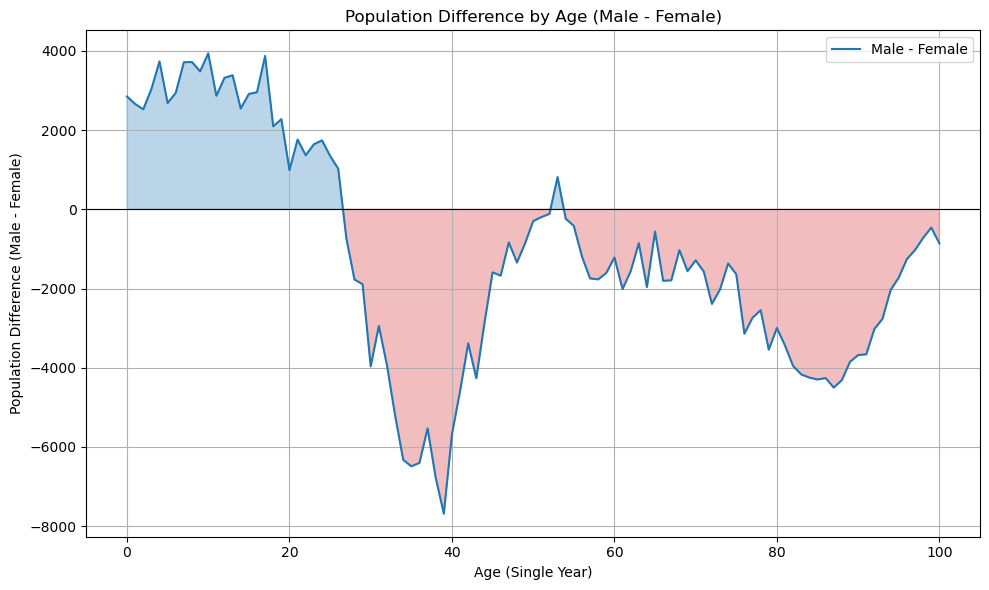

In [ ]:
import matplotlib.pyplot as plt

# Signed area plot / Diverging area chart — a line chart for a signed quantity with fill_between used to shade positive vs negative regions.
plt.figure(figsize=(10,6))
age_sex_diff_sorted = age_sex_diff.sort_index()
plt.plot(age_sex_diff_sorted.index, age_sex_diff_sorted['Difference'], label='Male - Female', color='tab:blue')
plt.fill_between(age_sex_diff_sorted.index, age_sex_diff_sorted['Difference'], where=age_sex_diff_sorted['Difference']>=0, interpolate=True, color='tab:blue', alpha=0.3)
plt.fill_between(age_sex_diff_sorted.index, age_sex_diff_sorted['Difference'], where=age_sex_diff_sorted['Difference']<0, interpolate=True, color='tab:red', alpha=0.3)
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel('Age (Single Year)')
plt.ylabel('Population Difference (Male - Female)')
plt.title('Population Difference by Age (Male - Female)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the plot as a png.
plt.savefig('age_sex_diff_by_age.png', dpi=150)
print('Saved age_sex_diff_by_age.png') # For confirmation
plt.show()

For the plot I used uses ```plt.plot(...)``` for the line, ```plt.fill_between(...)``` to shade in areas where the ```Difference``` is ≥0 (one color) vs <0 (another color), and ```plt.axhline(0)``` to draw the baseline. The benefits of the plot is that it makes it easier to visualise the data, but if overused details can be lost. In order to compare the different age groups of varying sizes normalising the data would be more accurate/beneficial for analysis.

### Part 2 - Make a variable that stores an age
- Write the codee that would group the people within 5 years of that age together into one age group
- Calculate the population difference between the sexes in that age group

In [12]:
# Part 2: Group people within 5 years of a given age and calculate population difference
age_of_interest = 32
age_group = df[(df['Single Year of Age'] >= age_of_interest - 5) & (df['Single Year of Age'] <= age_of_interest + 5)]

# Calculate total population by sex in this age group
pop_by_sex = age_group.groupby('Sex')['VALUE'].sum()
pop_diff = pop_by_sex['Male'] - pop_by_sex['Female']
print(f"Population by sex for ages {age_of_interest-5} to {age_of_interest+5}:")
print(pop_by_sex)

# Display which sex has larger population
if pop_diff > 0:
    print(f"Population difference: {pop_diff} more Males than Females")
else:
    print(f"Population difference: {abs(pop_diff)} more Females than Males")

Population by sex for ages 27 to 37:
Sex
Female    756242
Male      711040
Name: VALUE, dtype: int64
Population difference: 45202 more Females than Males


### Part 3 - Regions vs sexes
- Write the code that would work out which region in Ireland has the biggest population difference between the sexes in that age group.

In [13]:
# Part 3: Region with biggest population difference between sexes in the age group
# Reuse the age_group DataFrame from Part 2

age_group_counties = age_group[age_group['Administrative Counties'] != 'Ireland'] # Filter out 'Ireland' to keep only counties - should do this for the first and second parts too

region_diff = age_group_counties.pivot_table(index='Administrative Counties', columns='Sex', values='VALUE', aggfunc='sum')
region_diff['Difference'] = region_diff['Male'] - region_diff['Female']
max_diff_region = region_diff['Difference'].abs().idxmax()
max_diff_value = region_diff.loc[max_diff_region, 'Difference']

# Display result with positive value and sex indicator
print(f"County with biggest population difference (by absolute value) between sexes in ages {age_of_interest-5} to {age_of_interest+5}:")
if max_diff_value > 0:
    print(f"{max_diff_region}: {max_diff_value} more Males than Females")
else:
    print(f"{max_diff_region}: {abs(max_diff_value)} more Females than Males")

County with biggest population difference (by absolute value) between sexes in ages 27 to 37:
Fingal County Council: 2398 more Females than Males


## References

- Central Statistics Office (CSO) dataset: "Population by single year of age, administrative counties and sex" (FY006A). CSV download/API endpoint used:
  - https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/FY006A/CSV/1.0/en

- Methods and documentation:
  - Weighted mean / weighted average (used via numpy): https://numpy.org/doc/stable/reference/generated/numpy.average.html
  - pandas pivot_table and groupby (used for aggregations): https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html
  - Converting and cleaning age strings: pandas string methods docs: https://pandas.pydata.org/docs/reference/series.html#string-handling

- Notes:
  - The code uses `np.average(..., weights=...)` to compute the weighted mean age by sex, with population counts in the `VALUE` column used as weights.
  - The age-group logic in Part 2 groups people whose single year of age falls within ±5 years of the chosen `age_of_interest`.



# END